# Simulating flow

To use `bluebonnet.flow` in a project:

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy as sp
from scipy.interpolate import interp1d,UnivariateSpline
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz
from scipy import interpolate
from lmfit import minimize, Parameters,report_errors,conf_interval,Minimizer,printfuncs
from matplotlib.backends.backend_pdf import PdfPages
from FitFunctions import obfun

from bluebonnet.flow import (
    IdealReservoir, FlowProperties, 
    #FlowPropertiesMarder, 
    FlowPropertiesTwoPhase, 
    SinglePhaseReservoir, 
    #SinglePhaseReservoirMarder,
    RelPermParams, relative_permeabilities
)
from bluebonnet.fluids.fluid import Fluid, pseudopressure,BuildPVT
from bluebonnet.forecast.forecast_pressure import _obj_function as obfun,fit_production_pressure as FitProductionWithPressure,plot_production_comparison
from bluebonnet.fluids import HallYarbEOS
from bluebonnet import plotting
pd.set_option('display.max_rows', 100)
import pickle as pkl
Results={}

#import sys
#sys.path.insert(0,"/Users/michaelmarder/UTOneDrive/OneDrive - The University of Texas at Austin/Shale/bluebonnet/src/")
#plt.style.use("ggplot")

In [2]:
#Results=pkl.load(file=open("Results.pkl","rb"))

## Real gas simulation test case

In [2]:
Pi=12000
Pf=1000
Pf=5000

t_end = 10
time = np.linspace(0, np.sqrt(t_end), 10_000) ** 2
n_times=1000


t_end = 20
time = np.linspace(0, np.sqrt(t_end), n_times) ** 2
PressureTime=np.ones(n_times)
for i in range(n_times):
    if i<n_times/4: 
        PressureTime[i]=Pf 
    elif i<n_times/2:
        PressureTime[i]=Pf/2 
    else: 
        PressureTime[i]=Pf/4


pvt_gas = pd.read_csv("../tests/data/pvt_gas.csv").rename(
    columns={
        "P": "pressure",
        "Z-Factor": "z-factor",
        "Cg": "compressibility",
        "Viscosity": "viscosity",
    }
)


flow_propertiesM = FlowProperties(pvt_gas, Pi)

print('mf=',flow_propertiesM.m_scaled_func(Pf))

res_realgasM = SinglePhaseReservoir(100, Pf, Pi, flow_propertiesM)

%time res_realgasM.simulate(time,PressureTime)

rf2M = res_realgasM.recovery_factor()
rf2M[-1]


mf= 0.09720937870967307
CPU times: user 2.08 s, sys: 8.14 ms, total: 2.09 s
Wall time: 2.09 s


0.9101405177002068

In [3]:
(flow_propertiesM.pvt_props)

,T,pressure,z-factor,Bg,Density,compressibility,viscosity,pseudopressure,alpha,m-scaled
0,400,0,0.999577,0.294490,0.030003,0.068074,0.016332,0.000000e+00,899.427852,0.000000
1,400,10,0.999291,0.175194,0.050433,0.040521,0.016333,2.413310e+04,1510.983519,0.000002
2,400,20,0.999006,0.124664,0.070874,0.028850,0.016333,6.052784e+04,2122.152183,0.000004
3,400,30,0.998724,0.096745,0.091327,0.022402,0.016334,1.091900e+05,2732.928502,0.000008
4,400,40,0.998443,0.079035,0.111791,0.018311,0.016335,1.701252e+05,3343.308373,0.000013
...,...,...,...,...,...,...,...,...,...,...
1196,400,11960,1.502527,0.000543,16.263662,0.000040,0.029418,4.900670e+09,844363.803883,0.362633
1197,400,11970,1.503177,0.000543,16.270207,0.000040,0.029430,4.906088e+09,845152.743603,0.363034
1198,400,11980,1.503827,0.000543,16.276745,0.000040,0.029441,4.911506e+09,845941.674842,0.363435
1199,400,11990,1.504476,0.000543,16.283278,0.000040,0.029452,4.916925e+09,846730.597350,0.363836


0.3642368902150243
0.09720937870967307 0.0008833922400551281 Deviation is    -1%


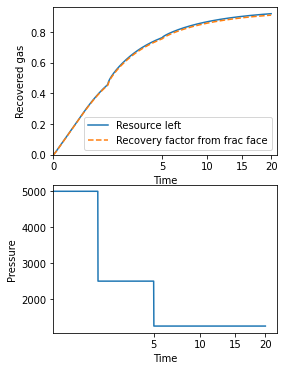

In [4]:
from scipy import interpolate
density_interp = interpolate.interp1d(flow_propertiesM.pvt_props["m-scaled"], flow_propertiesM.pvt_props["Density"])

def resource_left(pseudopressure, pvt):
    density = interpolate.interp1d(pvt.pvt_props["m-scaled"], pvt.pvt_props["Density"])
    print(max(pvt.pvt_props["m-scaled"]))
    p=np.minimum(pseudopressure,max(pvt.pvt_props["m-scaled"]))
    return (density(p)).sum(axis=1)/len(pseudopressure[0])
mf=flow_propertiesM.m_scaled_func(Pf)
mi=flow_propertiesM.m_scaled_func(Pi)


remaining_gasM = (resource_left(res_realgasM.pseudopressure, flow_propertiesM) )/(density_interp(mi))
print(mf,res_realgasM.pseudopressure[-1][0],'Deviation is {:5.2g}%'.format((rf2M[-1]-1+remaining_gasM[-1])/rf2M[-1]*100))
fig, (ax1,ax2) = plt.subplots(2,1)
fig.set_size_inches(4, 6)
ax1.plot(time, 1 - remaining_gasM, label="Resource left")
ax1.plot(time, rf2M,"--", label="Recovery factor from frac face")
ax1.legend()
ax1.set(xlabel="Time", ylabel="Recovered gas", ylim=(0,None), xscale='squareroot', xlim=(0,None))

ax2.plot(time, PressureTime , label="Pressure")
ax2.set(xlabel="Time",  xscale='squareroot',ylabel="Pressure")

pp=PdfPages('PressureCheck.pdf')
pp.savefig(fig)
pp.close()

# Create Equation of State

## Read in data about a particular well

In [5]:
WellNumber=12
Filename2="../../PressureData/SPE Well RTA Production Data/WellData_"+str(WellNumber)+".csv"
E=pd.read_csv(open(Filename2,"r"))
E=E.set_index('Field')
E=E.drop(columns='Unnamed: 0')
E.loc['Initial Pressure Estimate (psi)'][E.columns[0]]
Play=E.loc['Formation/Reservoir'][E.columns[0]]
E

,LORIKEET
Field,
Lease,LORIKEET
Well Number,62
State,LA
Formation/Reservoir,HAYNESVILLE SHALE
Initial Pressure Estimate (psi),9939
Reservoir Temperature (deg F),285.21375
Net Pay (ft),268.39703
Wellbore Diameter (ft),0.7
Porosity,0.0880000591278076


## Create equation of state from well data

In [6]:
FieldValues=E.iloc[:,0]
GasDryness='wet gas'
pvt_gas=BuildPVT(FieldValues,GasDryness)
pvt_gas.to_csv('../tests/data/pvt_gas_'+Play+'_'+str(WellNumber)+'.csv')


In [7]:
pvt_gas=pvt_gas.rename(
    columns={
        "P": "pressure",
        "Z-Factor": "z-factor",
        "Cg": "compressibility",
        "Viscosity": "viscosity",
    }
)
pvt_gas

,T,pressure,Density,z-factor,compressibility,viscosity,pseudopressure
0,285.21375,0.001,0.000002,1.000000,1000.000043,0.014637,0.000000e+00
1,285.21375,10.000,0.021024,0.999592,0.100043,0.014638,6.834483e+03
2,285.21375,20.000,0.042065,0.999181,0.050043,0.014638,2.734322e+04
3,285.21375,30.000,0.063123,0.998775,0.033376,0.014639,6.153650e+04
4,285.21375,40.000,0.084198,0.998370,0.025043,0.014639,1.094242e+05
...,...,...,...,...,...,...,...
1395,285.21375,13950.000,17.710554,1.655297,0.000029,0.029885,6.092854e+09
1396,285.21375,13960.000,17.715675,1.656005,0.000029,0.029895,6.098494e+09
1397,285.21375,13970.000,17.720791,1.656713,0.000029,0.029905,6.104133e+09
1398,285.21375,13980.000,17.725903,1.657421,0.000029,0.029915,6.109772e+09


# Plot all production data

/var/folders/mv/xtq5fvh134qc0zf3xwhl7ps80000gn/T/ipykernel_63125/3268703369.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1,ax2) = plt.subplots(1,2)


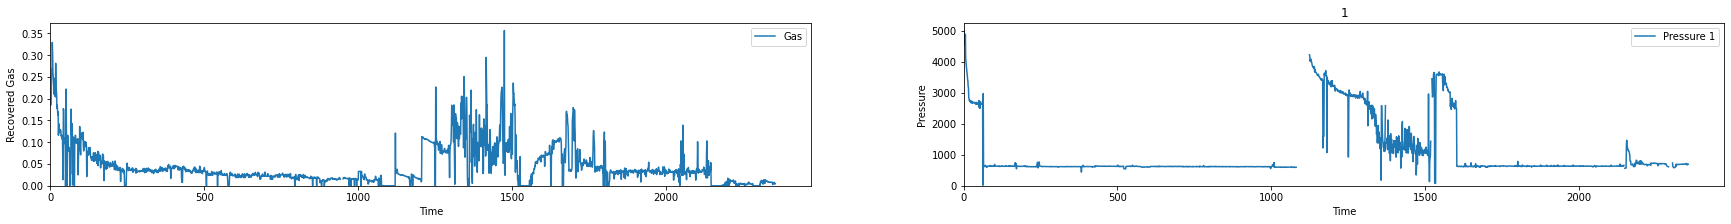

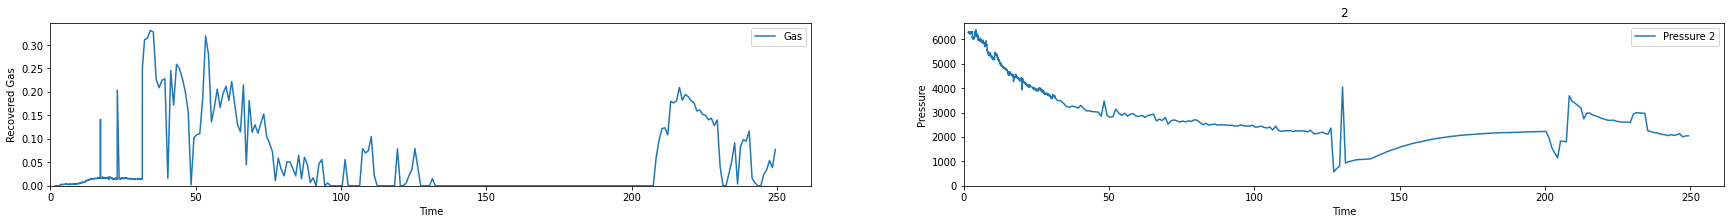

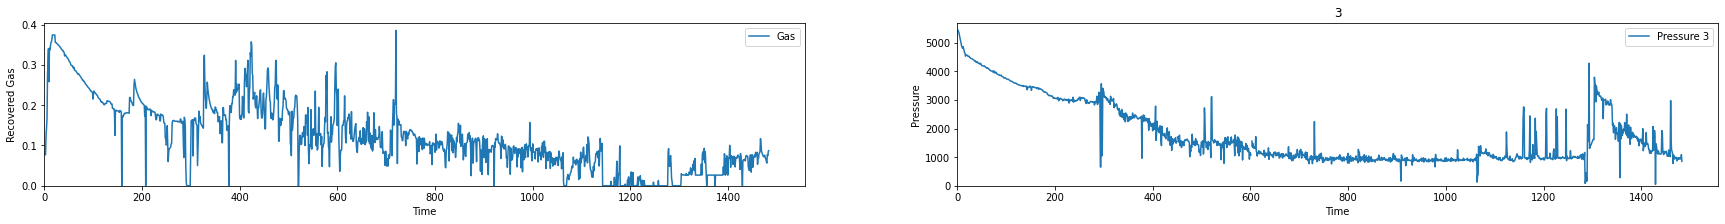

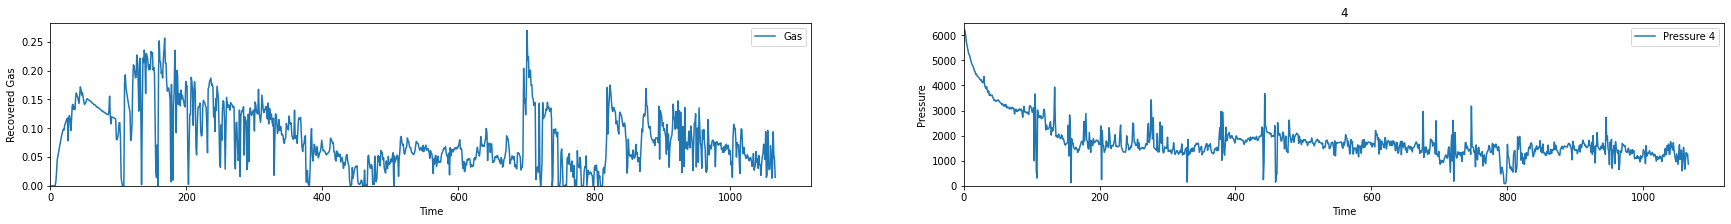

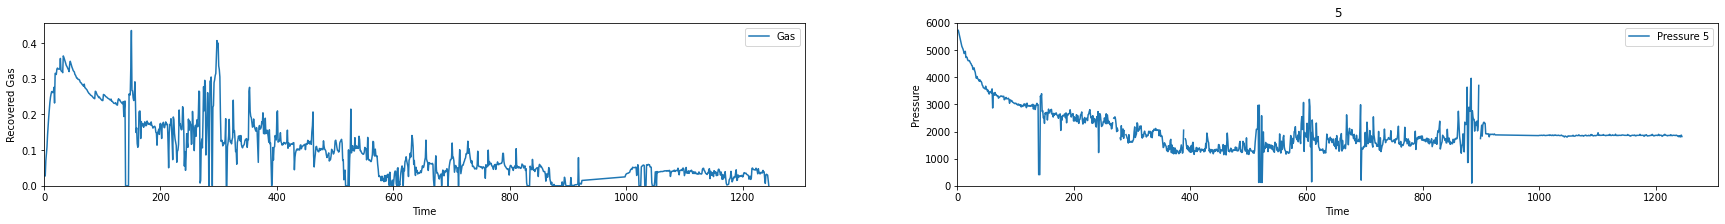

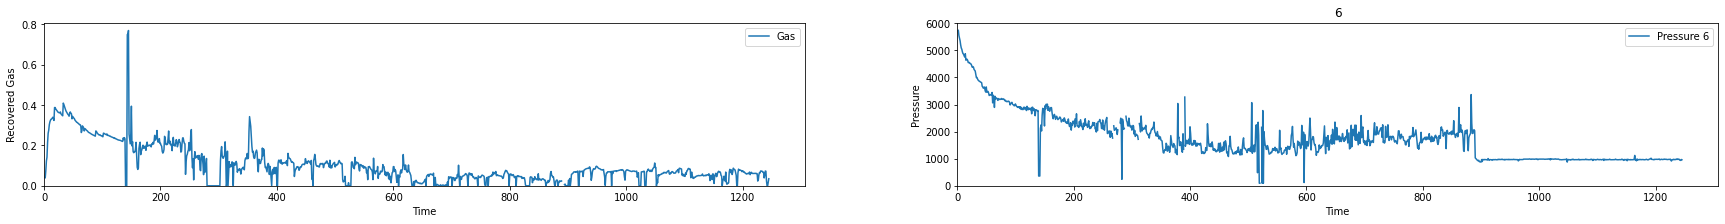

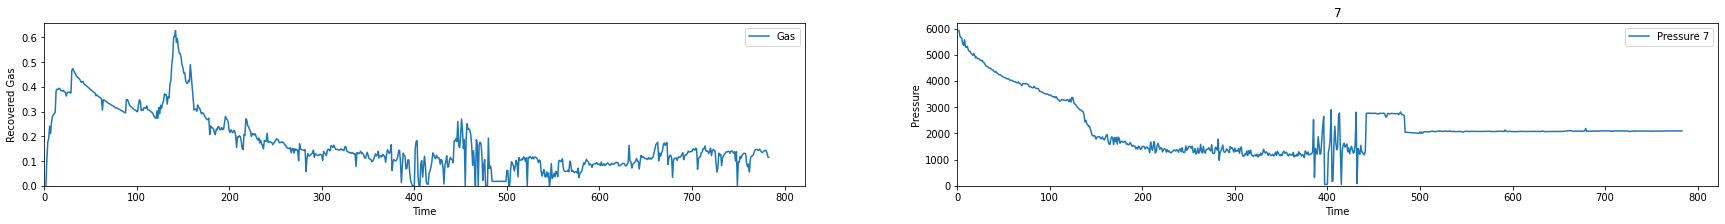

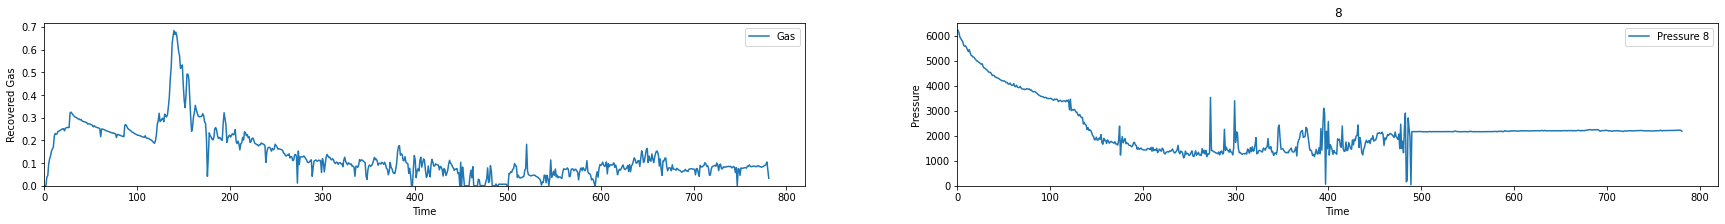

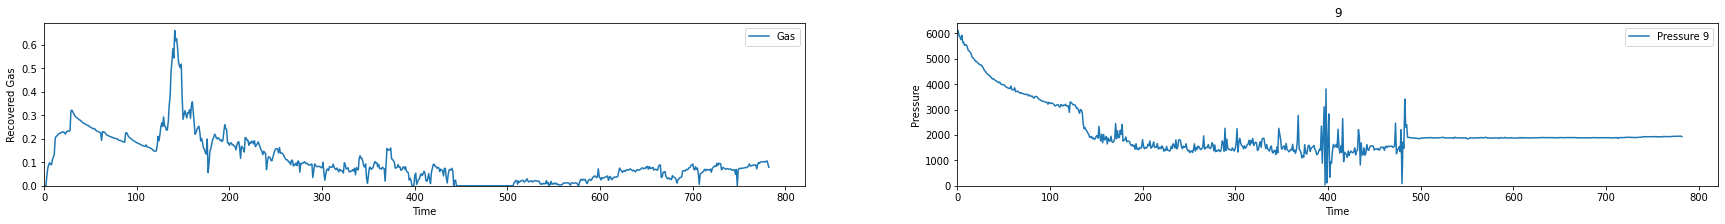

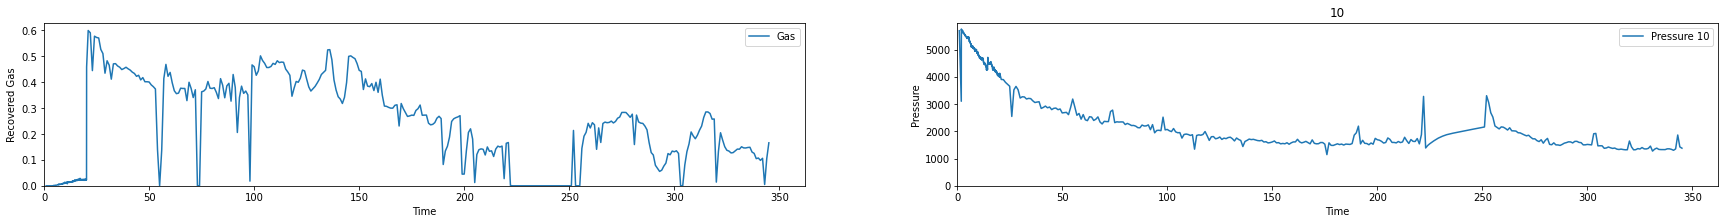

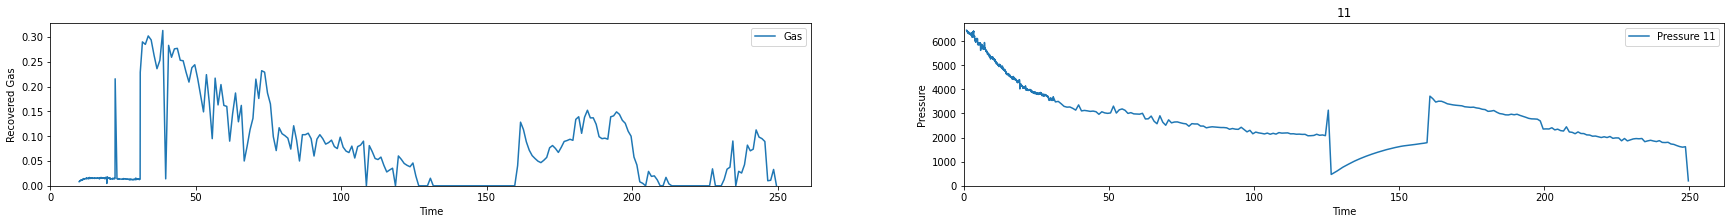

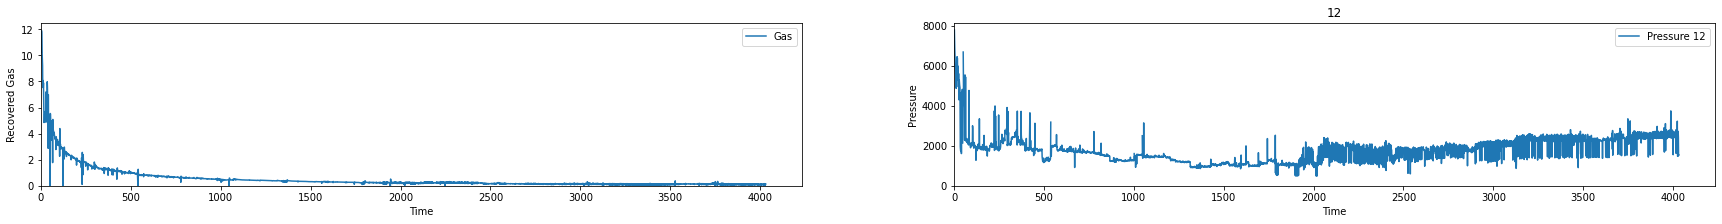

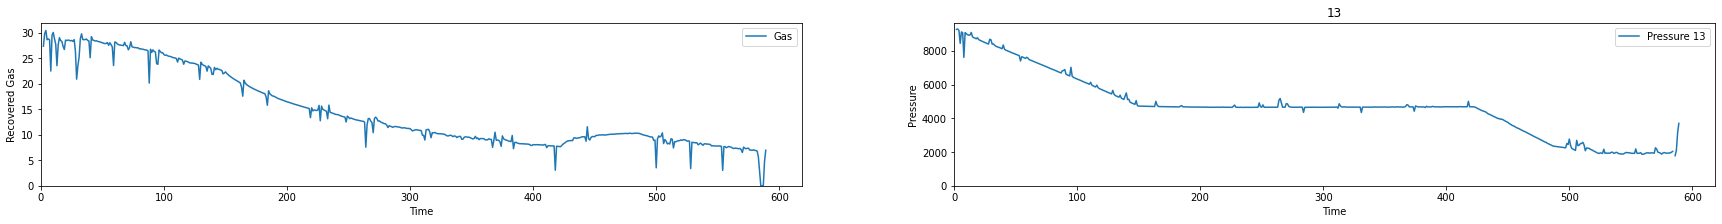

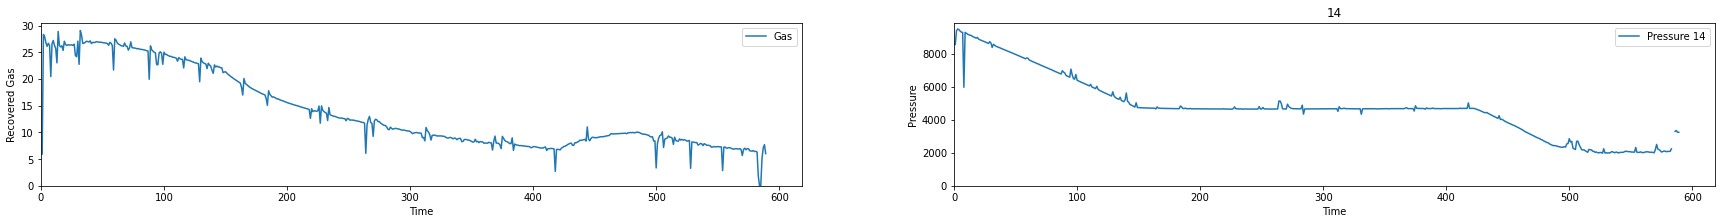

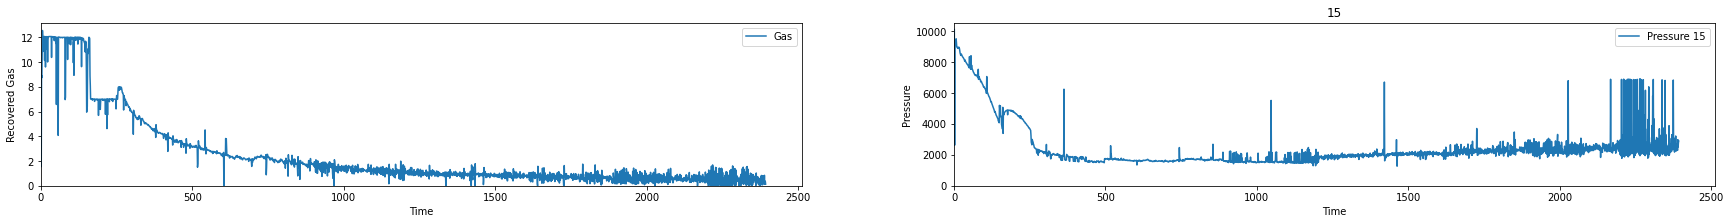

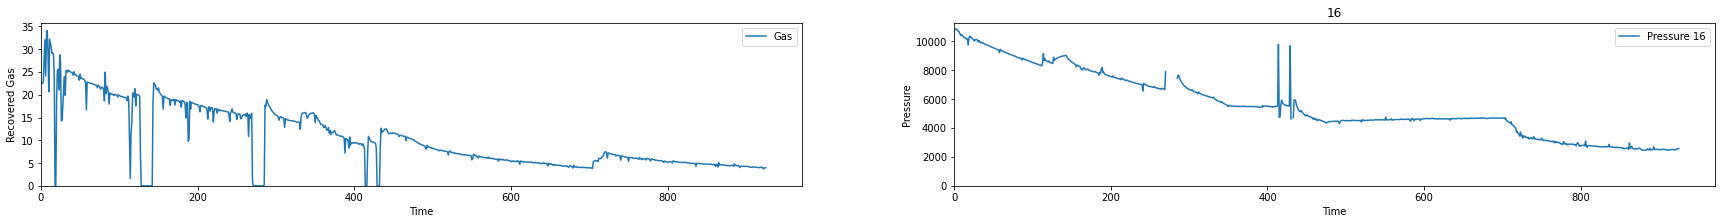

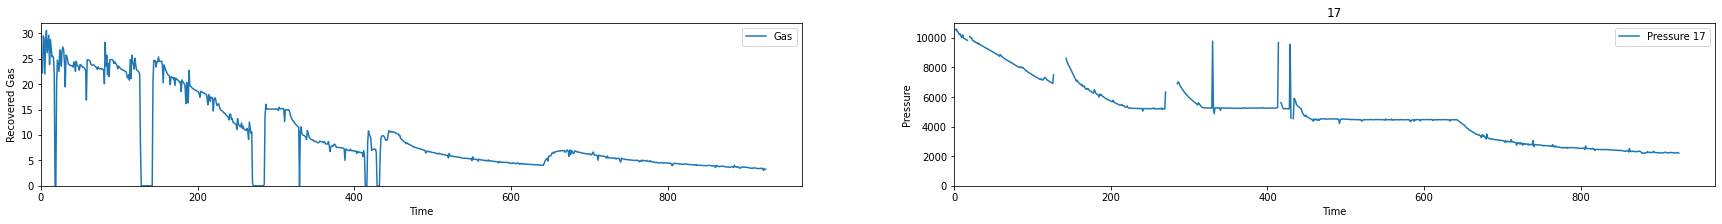

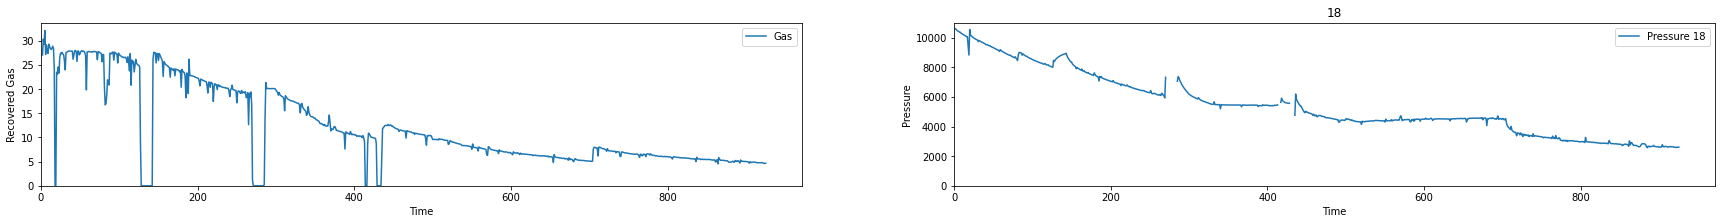

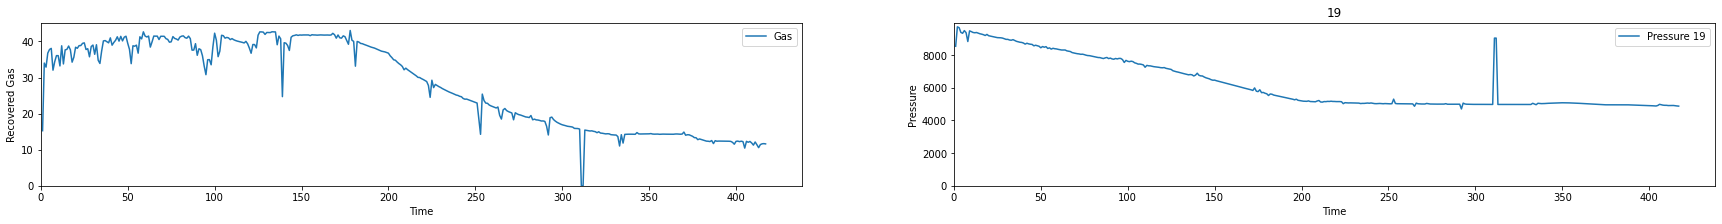

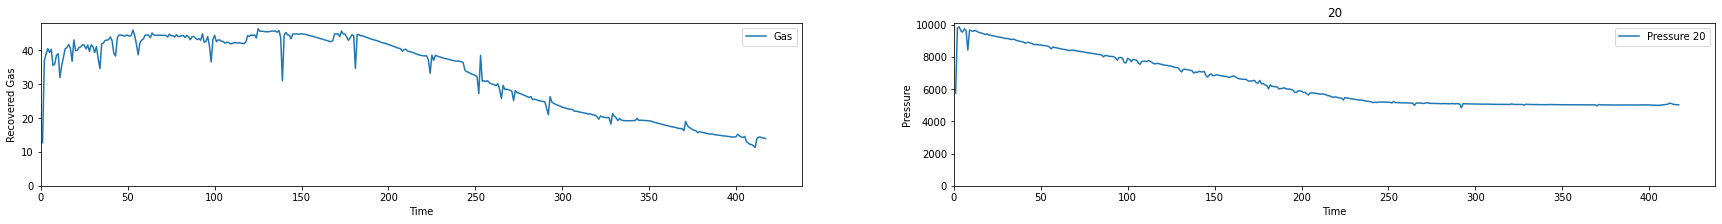

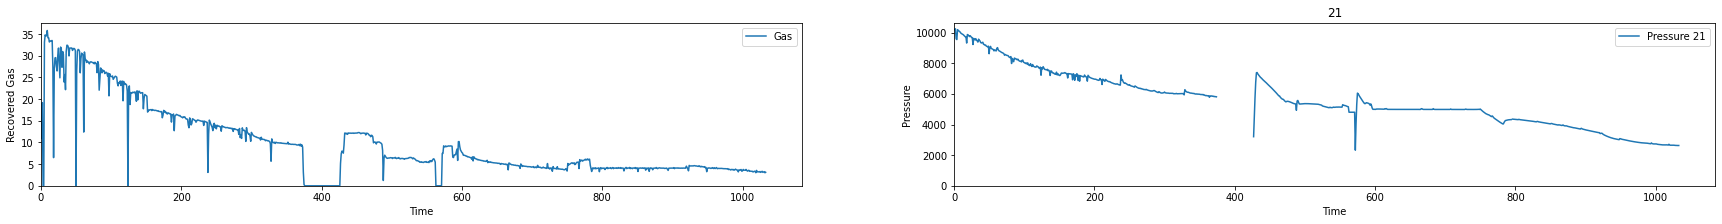

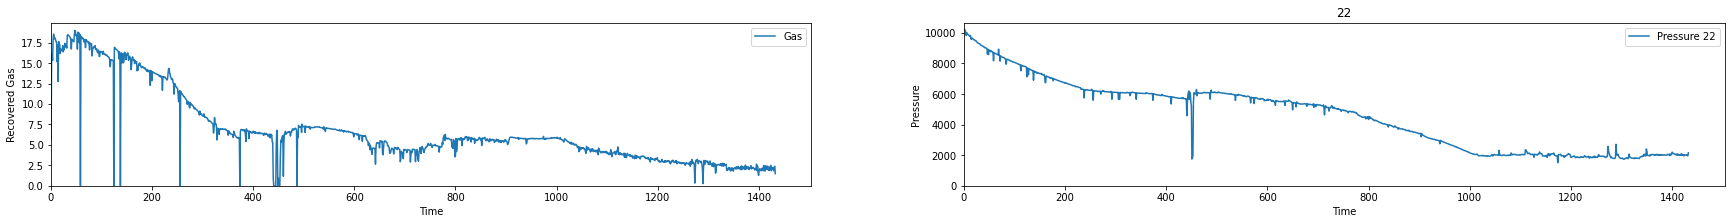

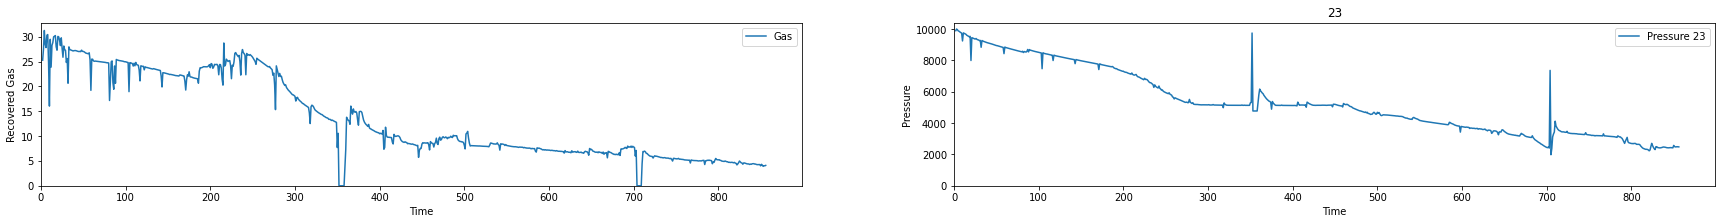

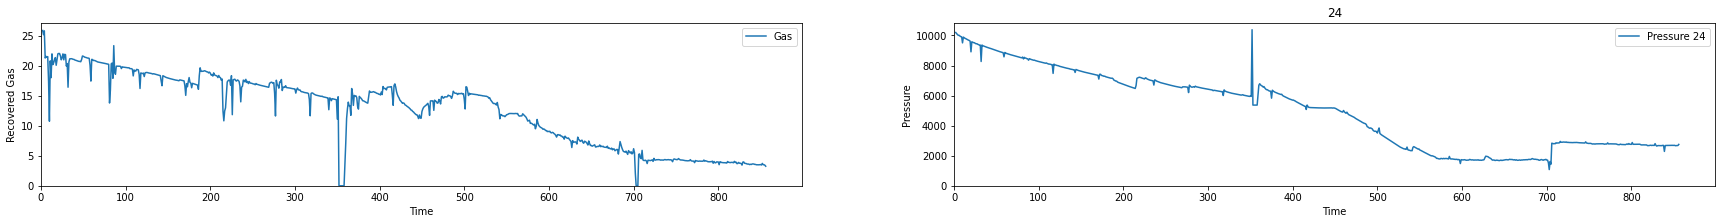

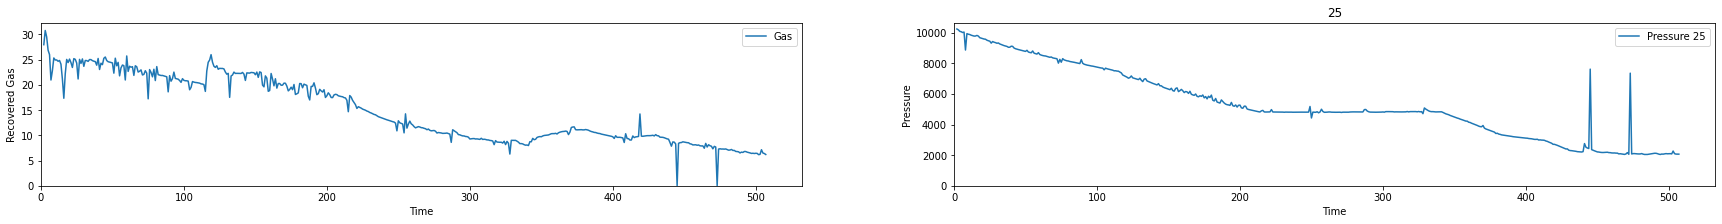

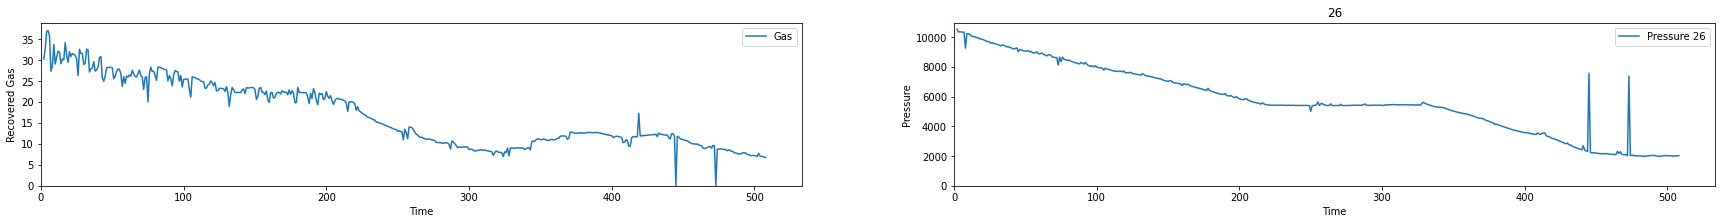

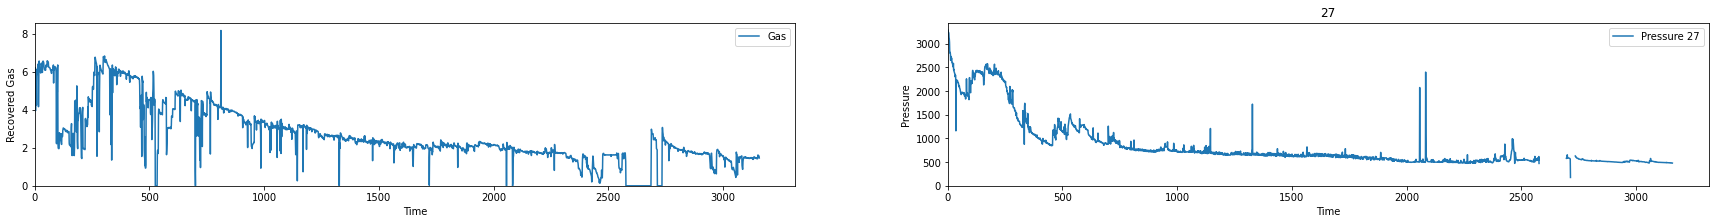

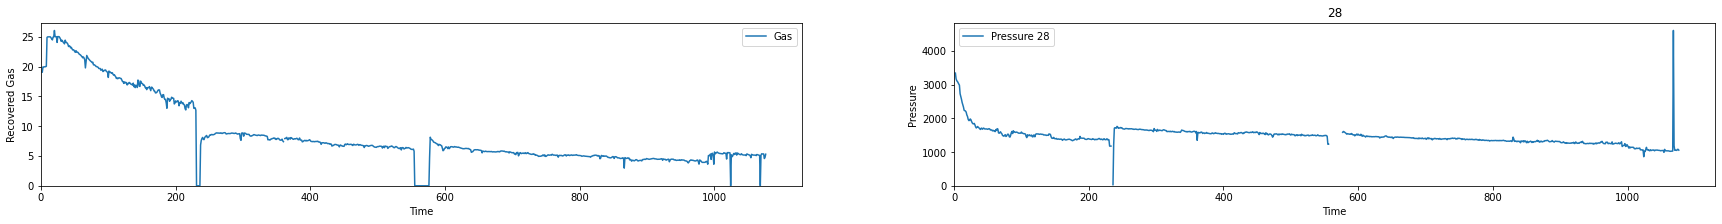

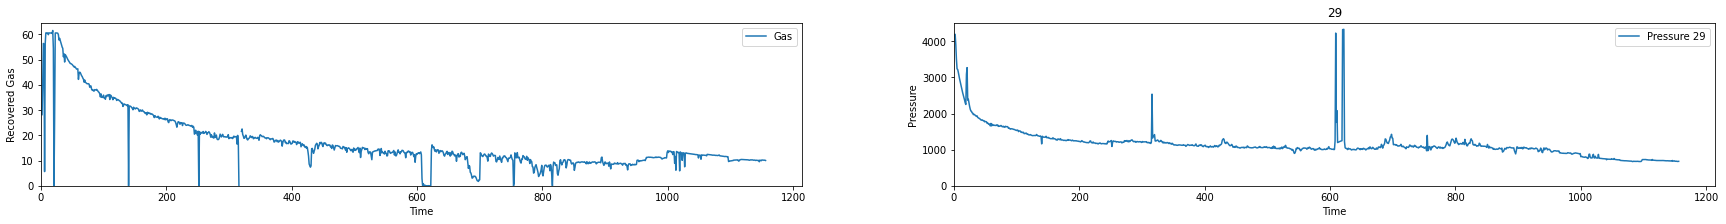

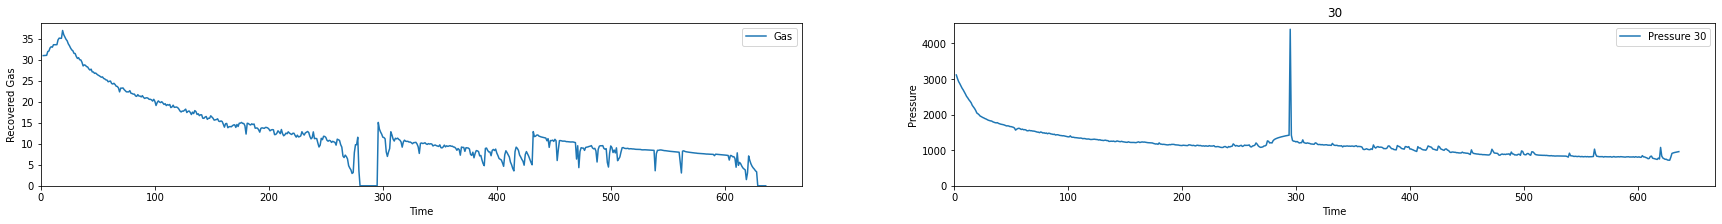

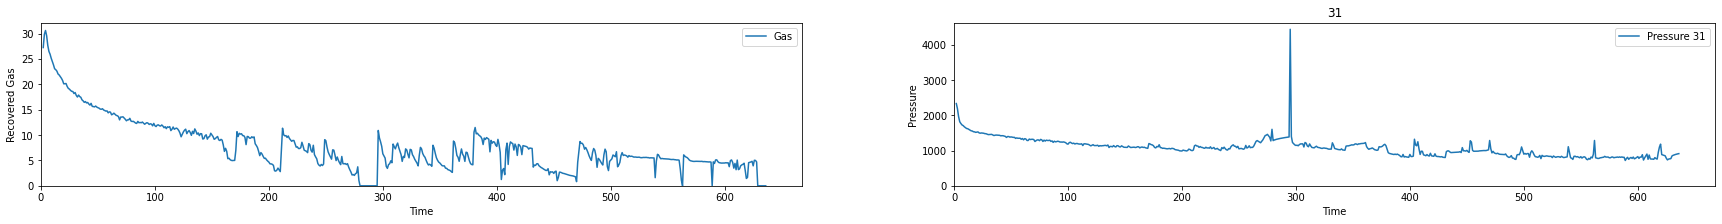

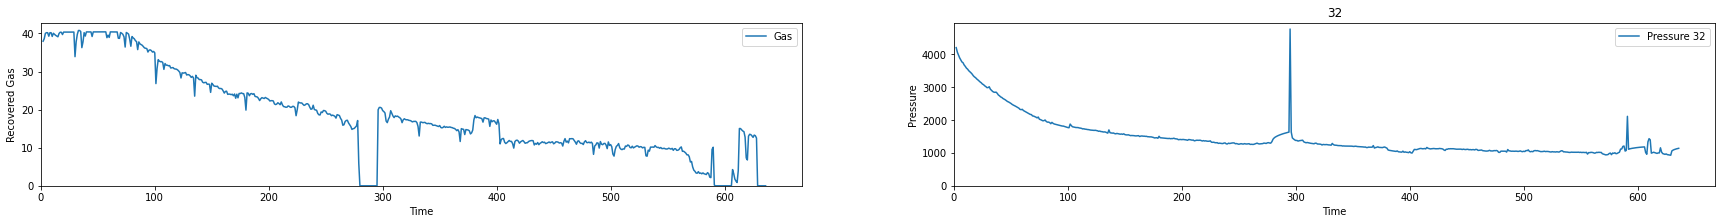

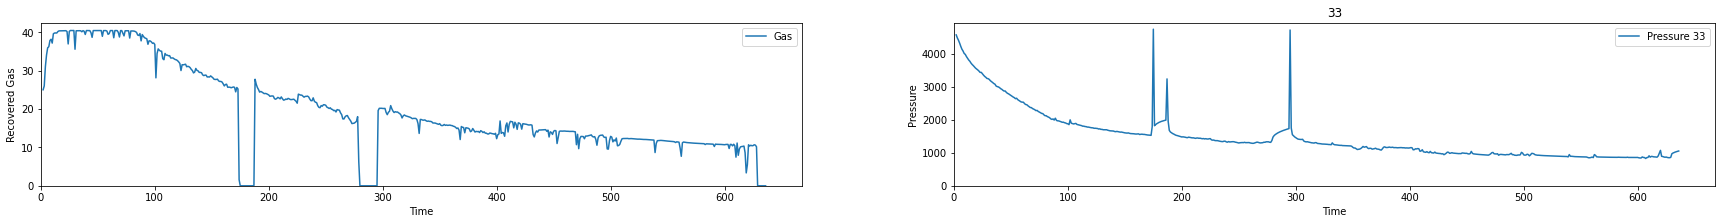

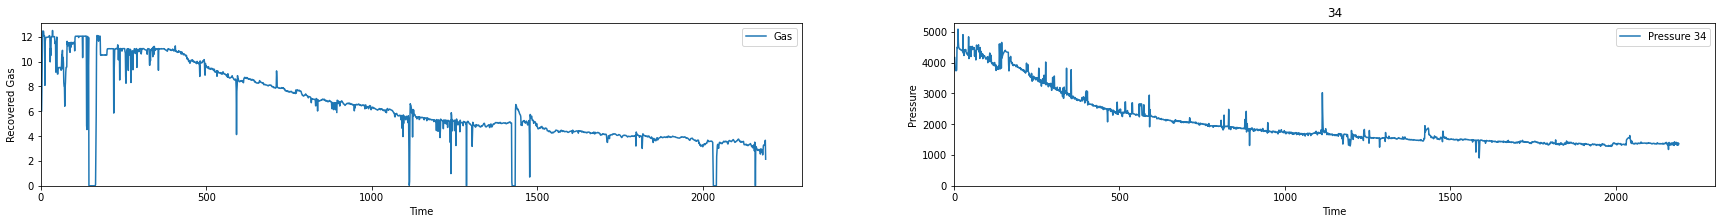

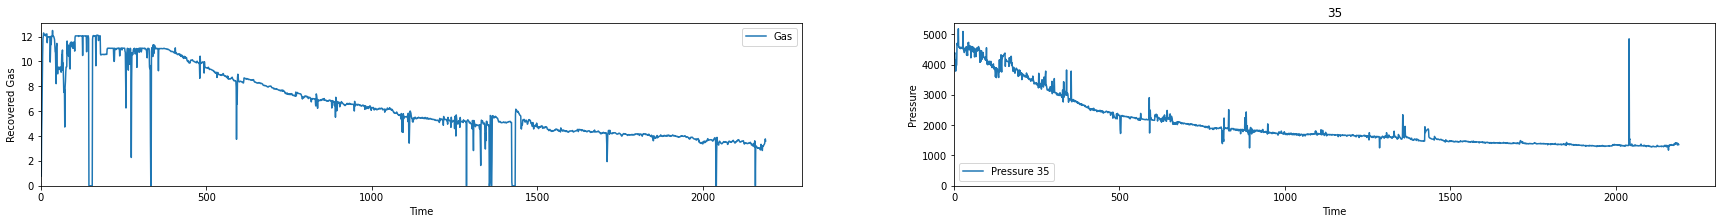

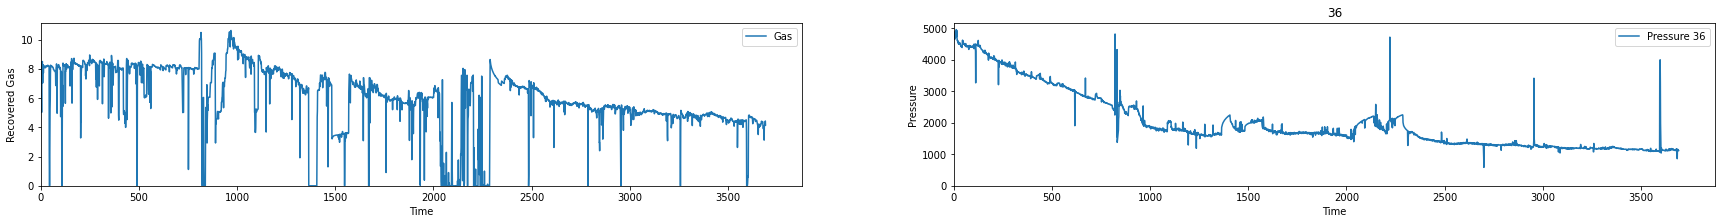

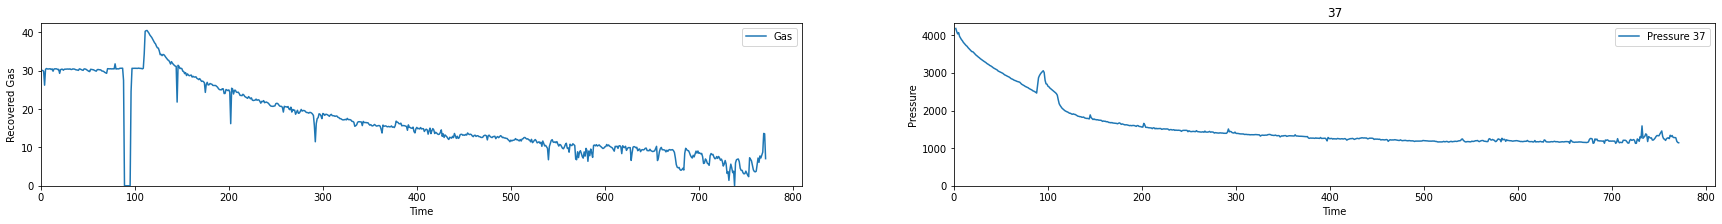

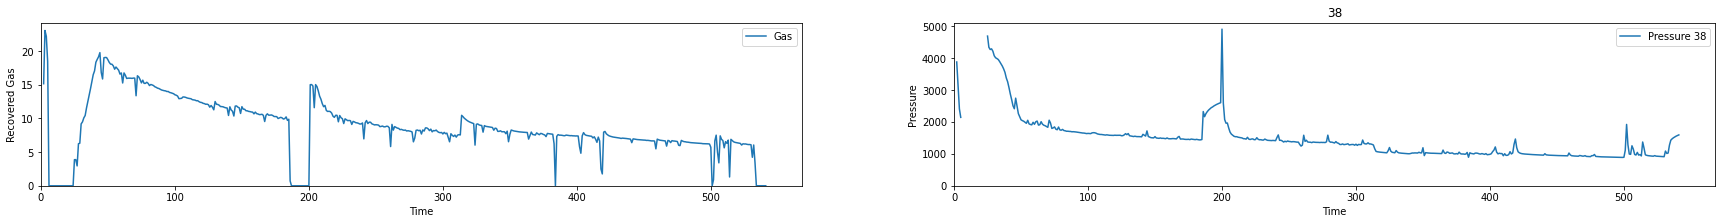

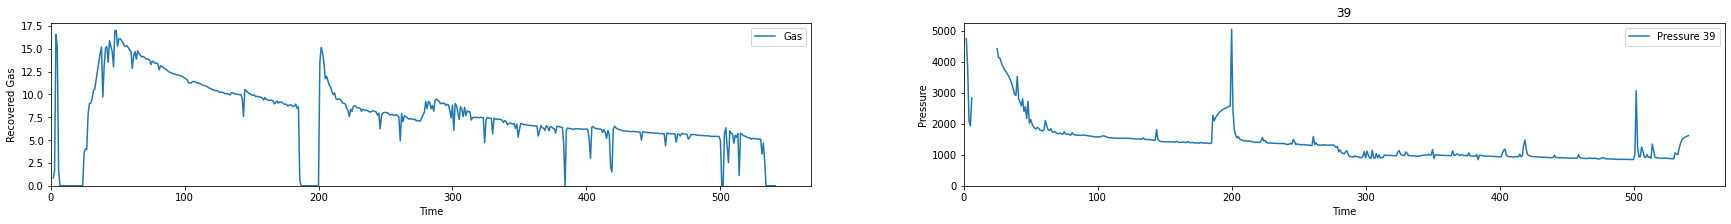

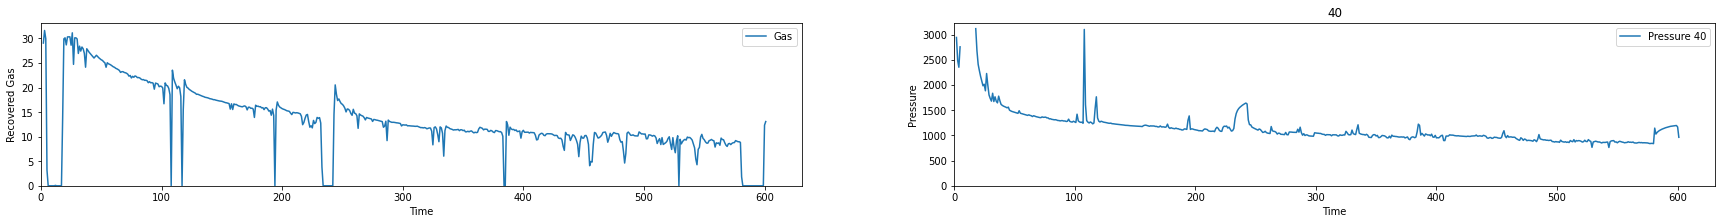

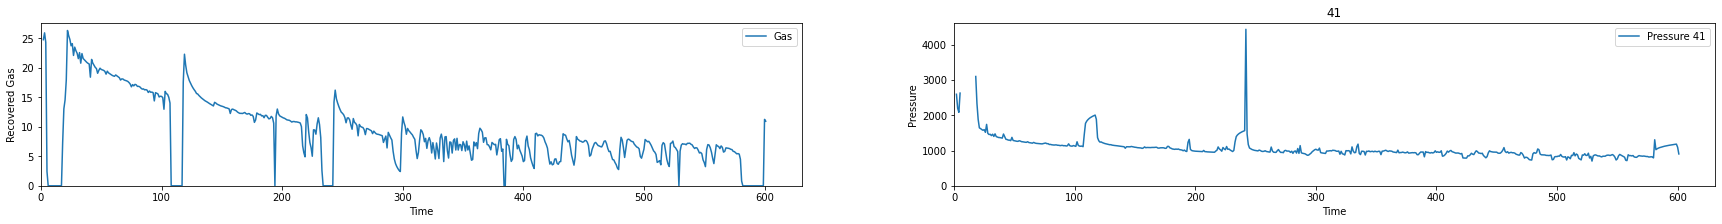

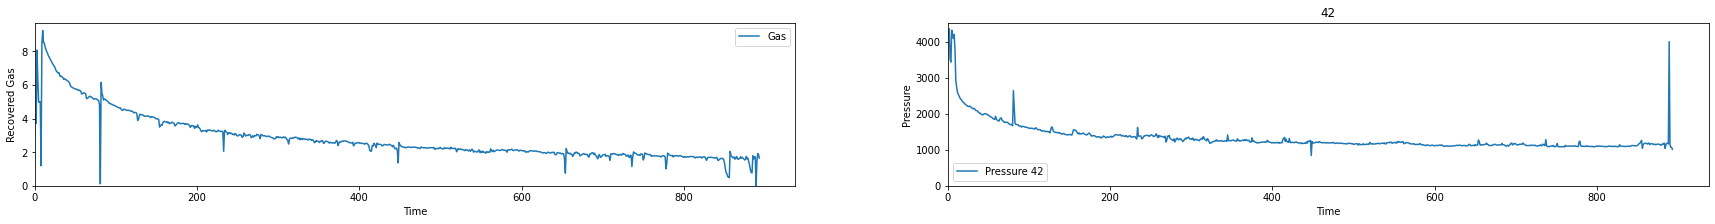

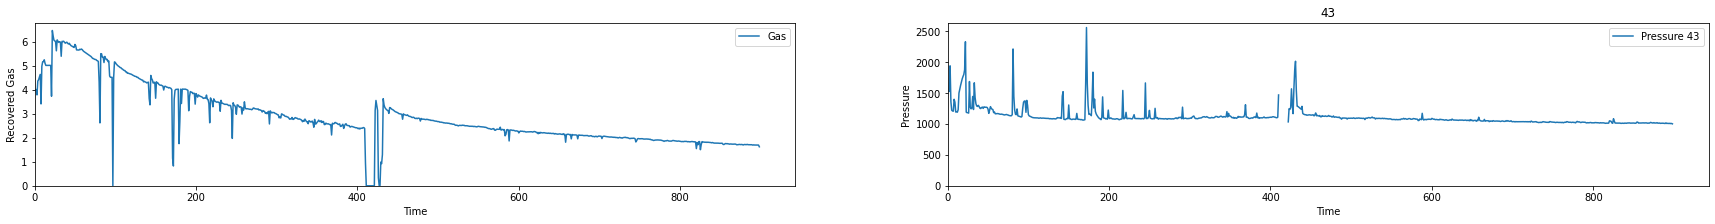

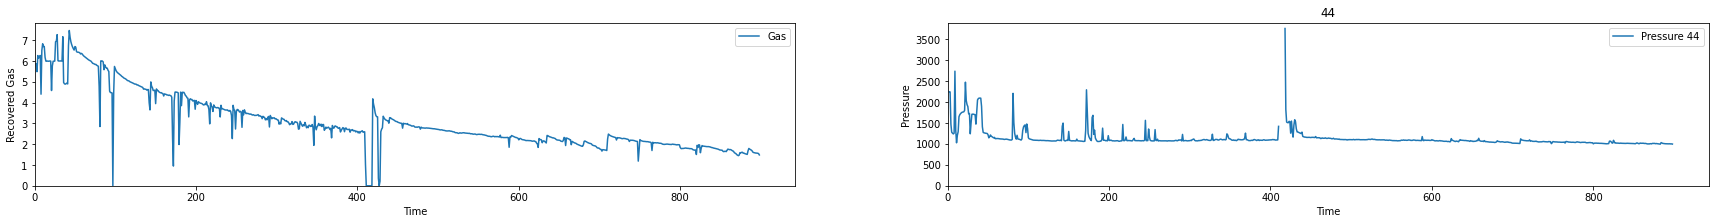

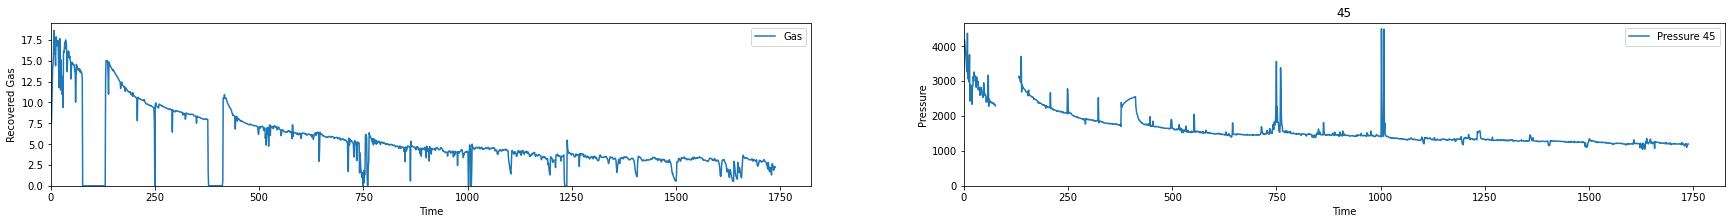

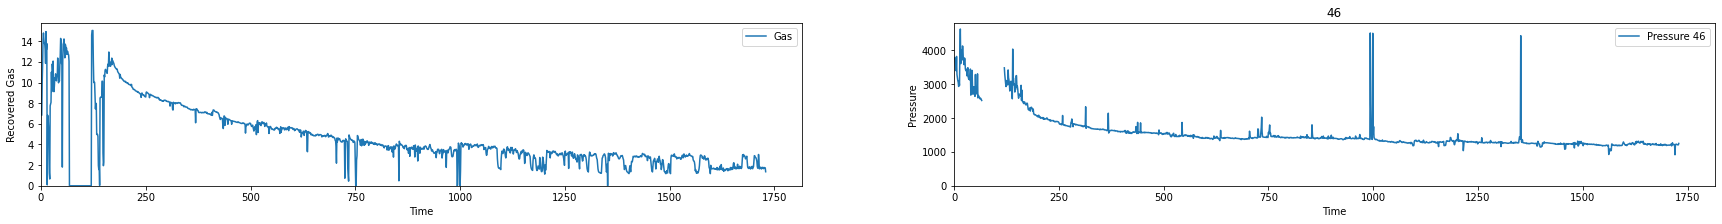

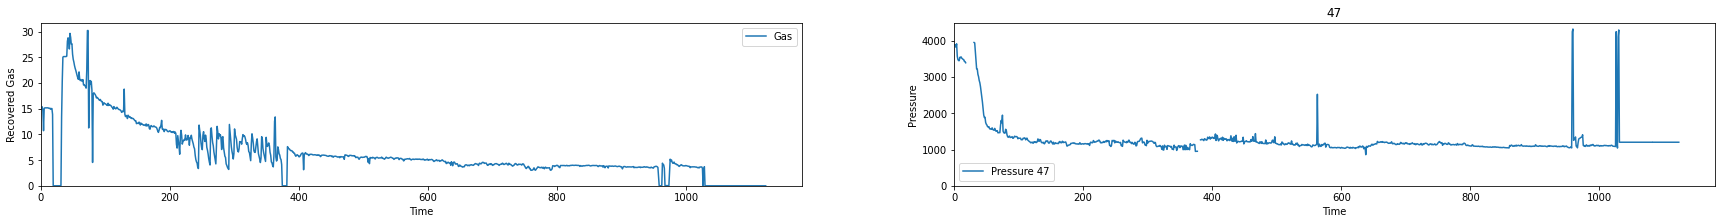

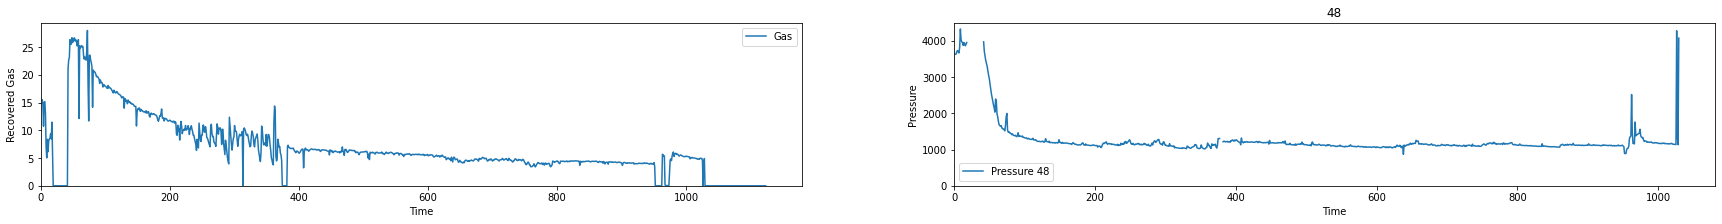

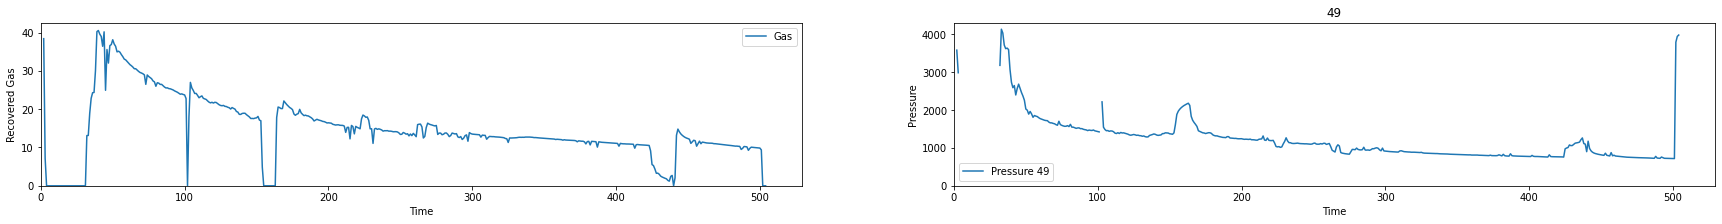

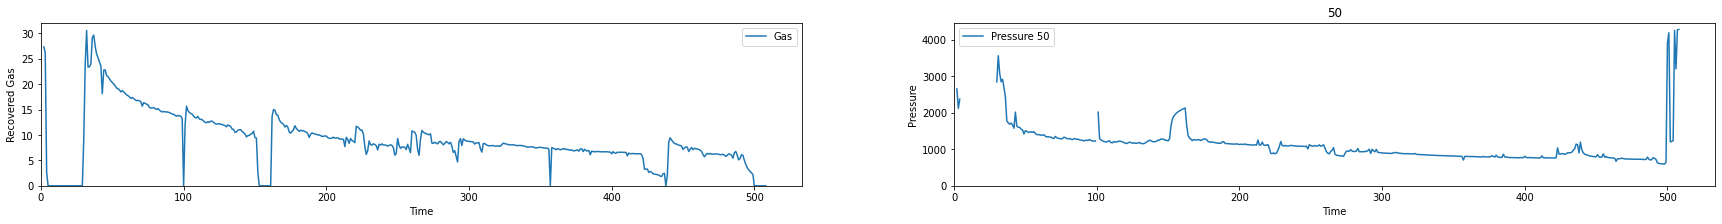

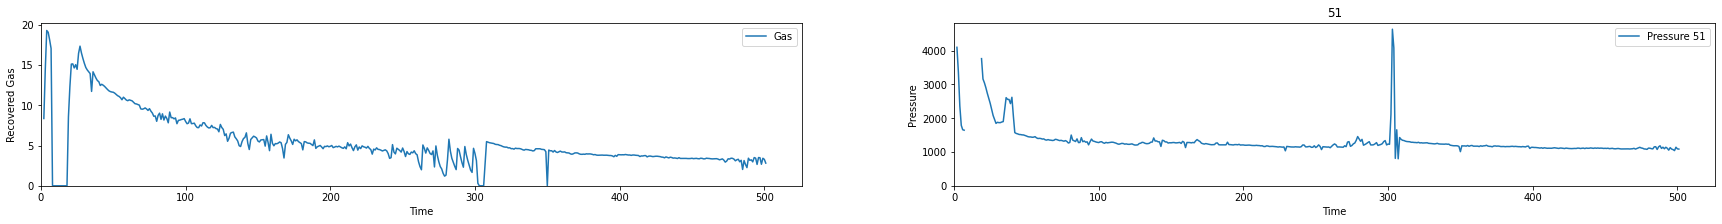

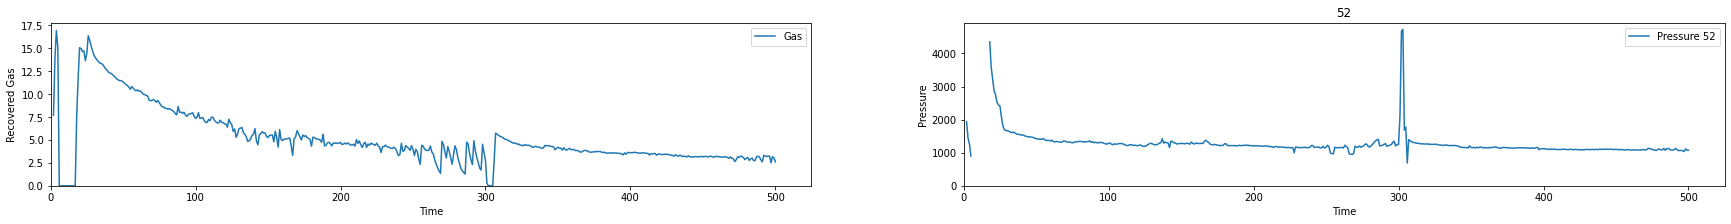

In [9]:
Type='Gas'
for WellNumber in range(1,53):
    Filename="../../PressureData/SPE Well RTA Production Data/dataset_1_well_"+str(WellNumber)+".csv"
    D=pd.read_csv(open(Filename,"r"),skiprows=[1,2])
    fig, (ax1,ax2) = plt.subplots(1,2)
    fig.set_size_inches(30, 3)
    ax1.plot(D['Days'], D[Type], label=Type)
    ax1.legend()
    ax1.set(xlabel="Time", ylabel="Recovered "+Type, ylim=(0,None), xscale='linear', xlim=(0,None))
    ax2.plot(D['Days'], D['Pressure'], label="Pressure "+str(WellNumber))
    ax2.legend()
    ax2.set(title=str(WellNumber))
    ax2.set(xlabel="Time", ylabel="Pressure", ylim=(0,None), xscale='linear', xlim=(0,None))


# Fit one well

In [85]:
WellNumber=19
Filename="../../PressureData/SPE Well RTA Production Data/dataset_1_well_"+str(WellNumber)+".csv"
D=pd.read_csv(open(Filename,"r"),skiprows=[1,2])
E=pd.read_csv(open(Filename2,"r"))
E=E.set_index('Field')
E=E.drop(columns='Unnamed: 0')
pressure_initial=float(E.loc['Initial Pressure Estimate (psi)'][E.columns[0]])


#if WellNumber in Results.keys():
#    result=FitProductionWithPressure(D,pvt_gas,Pi,NTimes,params=Results[WellNumber].params)
#else:
result=FitProductionWithPressure(D,pvt_gas,pressure_initial,n_iter=150,
                                 filter_window_size=30,
                                 pressure_imax=12000,
                                 inplace_max=100000)
Results[WellNumber]=result
result

 tau is     828, pressure_initial is    9939 and M is   11826
 tau is  826.77, pressure_initial is    9939 and M is   11826
 tau is     828, pressure_initial is    9939 and M is   11879
 tau is     828, pressure_initial is    9907 and M is   11826
 tau is  827.45, pressure_initial is  9971.6 and M is   11832
 tau is  826.48, pressure_initial is  9960.7 and M is   11902
 tau is  824.59, pressure_initial is  9971.6 and M is   12062
 tau is  827.62, pressure_initial is  9982.6 and M is   12303
 tau is  827.86, pressure_initial is   10005 and M is   13026
 tau is  827.45, pressure_initial is  9971.6 and M is   13026
 tau is  824.12, pressure_initial is   10027 and M is   14188
 tau is  819.28, pressure_initial is   10073 and M is   16539
 tau is  827.26, pressure_initial is   10061 and M is   17616
 tau is  827.86, pressure_initial is   10108 and M is   22909
 tau is  825.03, pressure_initial is   10155 and M is   22658
 tau is  819.04, pressure_initial is   10223 and M is   33495
 tau is 

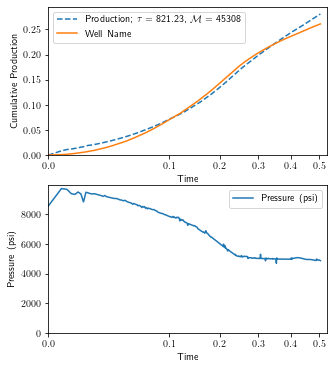

In [87]:
plt,(ax1,ax2)=plot_production_comparison(
    D,
    pvt_gas,
    result.params
)

# Find Many M-tau values

In [70]:
for WellNumber in range(21,22): 
    Filename="../../PressureData/SPE Well RTA Production Data/dataset_1_well_"+str(WellNumber)+".csv"
    # This file contains pressure and production data. Rows 1 and 2 have information about units, so skip
    D=pd.read_csv(open(Filename,"r"),skiprows=[1,2])
    E=pd.read_csv(open(Filename2,"r"))
    # This file contains an estimate of initial pressure. That's all I need it for here.
    E=E.set_index('Field')
    E=E.drop(columns='Unnamed: 0')
    Pi=float(E.loc['Initial Pressure Estimate (psi)'][E.columns[0]])
    pressure_initial=Pi
    NTimes=100
    print("\nStarting well ",str(WellNumber),"\n")

    if WellNumber in Results.keys():
        result=FitProductionWithPressure(D,
                                        pvt_gas,
                                        pressure_initial,
                                        n_iter=NTimes/2,
                                        pressure_imax=12000,
                                        filter_window_size=30,
                                        inplace_max=100000,
                                        params=Results[WellNumber].params)
    else:
        result=FitProductionWithPressure(D,
                                        pvt_gas,
                                        pressure_initial,
                                        n_iter=NTimes,
                                        pressure_imax=12000,
                                        filter_window_size=30,
                                        inplace_max=100000)
    Results[WellNumber]=result
    


Starting well  21 

 tau is    1000, pressure_initial is  9981.7 and M is   10086


KeyError: 2

CPU times: user 1.1 s, sys: 3.06 ms, total: 1.11 s
Wall time: 1.11 s
tau= 124.23, Pi=  10980 and M=   39129
CPU times: user 2.51 s, sys: 11.8 ms, total: 2.52 s
Wall time: 2.52 s
tau= 115.12, Pi=  12000 and M=   21674
CPU times: user 2.56 s, sys: 9.03 ms, total: 2.56 s
Wall time: 2.57 s
tau=  275.9, Pi=  12290 and M=   17627
CPU times: user 2.34 s, sys: 7.25 ms, total: 2.35 s
Wall time: 2.35 s
tau= 88.118, Pi=  12290 and M=   21859
CPU times: user 1.04 s, sys: 4.1 ms, total: 1.05 s
Wall time: 1.05 s
tau= 966.33, Pi=  11563 and M=   35491
CPU times: user 660 ms, sys: 1.36 ms, total: 661 ms
Wall time: 662 ms
tau=  897.4, Pi=  12286 and M=   32271
CPU times: user 666 ms, sys: 1.7 ms, total: 667 ms
Wall time: 668 ms
tau= 999.04, Pi=  12018 and M=   42042


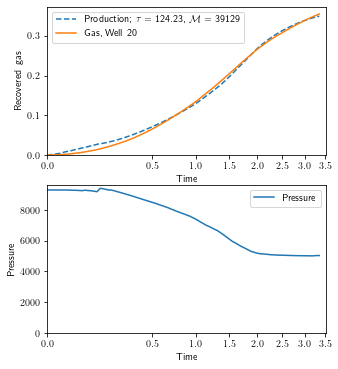

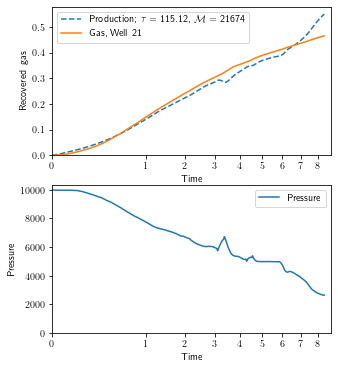

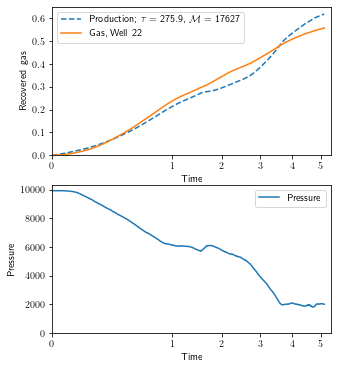

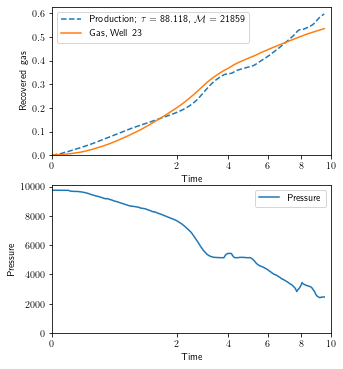

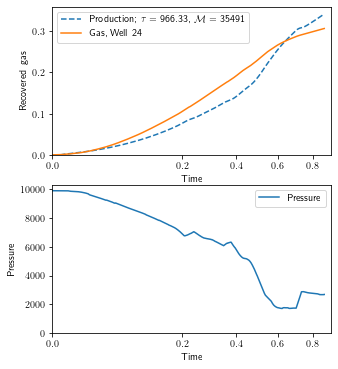

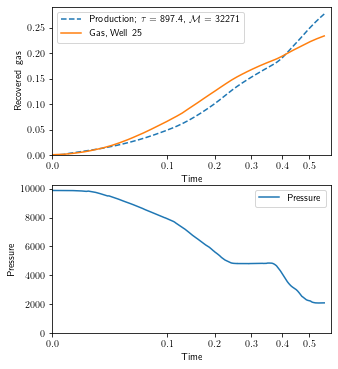

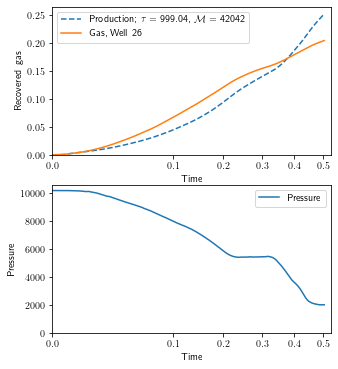

In [11]:
plt.rcParams['text.usetex'] = True
for WellNumber in range(20,27):#Results.keys():
    
    
    
    Filename="../../PressureData/SPE Well RTA Production Data/dataset_1_well_"+str(WellNumber)+".csv"
    D=pd.read_csv(open(Filename,"r"),skiprows=[1,2])
    Filename2="../../PressureData/SPE Well RTA Production Data/WellData_"+str(WellNumber)+".csv"
    E=pd.read_csv(open(Filename2,"r"))
    E.set_index("Field")
    Data=D[(D['Gas']>0) & (pd.notna(D['Pressure']))][['Days','Gas','Pressure']]

    GoodDays = np.array(Data['Days'])
    Days=np.arange(0,len(GoodDays))
    PressureTime=np.array(Data['Pressure'])
    #
    Nave=30
    PressureTime=sp.ndimage.filters.uniform_filter1d(PressureTime, size=Nave)
    #
    Gas=np.cumsum(np.array(Data['Gas']))
    M=Results[WellNumber].params['M'].value
    tau=Results[WellNumber].params['tau'].value
    Pi=Results[WellNumber].params['Pi'].value
    Pf=Pi

    flow_propertiesM = FlowPropertiesMarder(pvt_gas, Pi)
    res_realgasM = SinglePhaseReservoirMarder(80, Pf, Pi, flow_propertiesM)
    %time res_realgasM.simulate(Days/tau,PressureTime=PressureTime)
    print('tau={:7.5g}, Pi={:7.5g} and M={:8.5g}'.format(tau,Pi,M))
    rf2M = res_realgasM.recovery_factor()
    fig, (ax1,ax2) = plt.subplots(2,1)
    fig.set_size_inches(5, 6)
    ax1.plot(Days/tau, rf2M,"--", label=r"Production; $\tau=${:7.5g}, $\mathcal M=${:7.5g}".format(tau,M))
    ax1.plot(Days/tau, Gas/M, label="Gas, Well "+str(WellNumber))
    ax1.legend()
    ax1.set(xlabel="Time", ylabel="Recovered gas", ylim=(0,None), xscale='squareroot', xlim=(0,None))

    ax2.plot(Days/tau, PressureTime, label="Pressure")
    ax2.legend()
    ax2.set(xlabel="Time", ylabel="Pressure", ylim=(0,None), xscale='squareroot', xlim=(0,None))

    pp=PdfPages('Wells'+str(WellNumber)+'.pdf')
    pp.savefig(fig)
    pp.close()


In [ ]:
pkl.dump(Results,file=open("Results.pkl","wb"))

# Repeat results but without varying pressure

In [14]:
ResultsNP={}

In [27]:
M0=10
MMax=100000
from FitFunctions import obfun

for WellNumber in range(20,21):
    Filename="../../PressureData/SPE Well RTA Production Data/dataset_1_well_"+str(WellNumber)+".csv"
    D=pd.read_csv(open(Filename,"r"),skiprows=[1,2])
    Filename2="../../PressureData/SPE Well RTA Production Data/WellData_"+str(WellNumber)+".csv"
    E=pd.read_csv(open(Filename2,"r"))
    E.set_index("Field")
    Data=D[(D['Gas']>0) & (pd.notna(D['Pressure']))][['Days','Gas','Pressure']]

    GoodDays = np.array(Data['Days'])
    Days=np.arange(0,len(GoodDays))
    PressureTime=np.array(Data['Pressure'])
    for i in range(len(PressureTime)): #Set to last value
        PressureTime[i]=PressureTime[len(PressureTime)-1]
    #
    Nave=30
    PressureTime=sp.ndimage.filters.uniform_filter1d(PressureTime, size=Nave)
    #
    Gas=np.cumsum(np.array(Data['Gas']))

    if (WellNumber<12): #the low numbers are oil wells
        Pi=PressureTime[0]
    else:
        Pi=max(float(E.iloc[4][2]),max(PressureTime))
    Pf=Pi

    if (WellNumber in Results.keys()):
        params=Results[WellNumber].params
        params['Pi'].set(max=14000)
        NTimes=100
    else:
        params=Parameters()
        params.add('tau',value=1000.0,min=30.0,max=Days[-1]*2) #Days
        params.add('M',value=Gas[-1],min=Gas[-2],max=MMax) #MMcf
        params.add('Pi',value=Pi,min=max(PressureTime),max=14000) #MMcf
        NTimes=100
    mini=Minimizer(obfun,params,fcn_args=(Days,Gas,pvt_gas,PressureTime))
    result=mini.minimize(method='Nelder',max_nfev=NTimes)
    print('Finished Nelder minimization with tau={:7.5g}, Pi={:7.5g} and M={:8.5g}'.format(result.params['tau'].value,result.params['Pi'].value,result.params['M'].value))
    #result=mini.minimize(method='leastsq',xtol=1.e-4,params=result.params)
    #print('Finished lstsqr minimization with tau={:5.2g} and M={:5.2g}'.format(result.params['tau'].value,result.params['M'].value))
    print(' ##### {:} #####'.format(WellNumber))
    ResultsNP[WellNumber]=result

Simulation took   1.1 s; tau is  124.23, Pi is   10980 and M is   39129
Simulation took   1.2 s; tau is  113.28, Pi is   10980 and M is   39129
Simulation took   1.1 s; tau is  124.23, Pi is   10980 and M is   38595
Simulation took   1.1 s; tau is  124.23, Pi is   10945 and M is   39129
Simulation took   1.1 s; tau is  135.77, Pi is   10957 and M is   38773
Simulation took   1.1 s; tau is  147.86, Pi is   10945 and M is   38595
Simulation took   1.1 s; tau is  139.74, Pi is   10934 and M is   38417
Simulation took   1.1 s; tau is  150.62, Pi is   10961 and M is   37944
Simulation took     1 s; tau is  164.82, Pi is   10968 and M is   37354
Simulation took  0.98 s; tau is  179.64, Pi is   10918 and M is   37648
Simulation took  0.96 s; tau is  211.01, Pi is   10888 and M is   37177
Simulation took  0.93 s; tau is  211.01, Pi is   10934 and M is   37000
Simulation took  0.89 s; tau is  251.34, Pi is   10934 and M is   36296
Simulation took  0.85 s; tau is  276.02, Pi is   10914 and M is 

CPU times: user 592 ms, sys: 1.81 ms, total: 594 ms
Wall time: 594 ms
tau=  831.7, Pi= 9725.6 and M=   62289


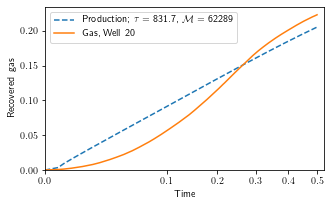

In [29]:
plt.rcParams['text.usetex'] = True
for WellNumber in range(20,21):#Results.keys():
    Filename="../../PressureData/SPE Well RTA Production Data/dataset_1_well_"+str(WellNumber)+".csv"
    D=pd.read_csv(open(Filename,"r"),skiprows=[1,2])
    Filename2="../../PressureData/SPE Well RTA Production Data/WellData_"+str(WellNumber)+".csv"
    E=pd.read_csv(open(Filename2,"r"))
    E.set_index("Field")
    Data=D[(D['Gas']>0) & (pd.notna(D['Pressure']))][['Days','Gas','Pressure']]

    GoodDays = np.array(Data['Days'])
    Days=np.arange(0,len(GoodDays))
    PressureTime=np.array(Data['Pressure'])
    for i in range(len(PressureTime)): #Set to last value
        PressureTime[i]=PressureTime[len(PressureTime)-1]
    #
    Nave=30
    PressureTime=sp.ndimage.filters.uniform_filter1d(PressureTime, size=Nave)
    #
    Gas=np.cumsum(np.array(Data['Gas']))
    M=ResultsNP[WellNumber].params['M'].value
    tau=ResultsNP[WellNumber].params['tau'].value
    Pi=ResultsNP[WellNumber].params['Pi'].value
    Pf=Pi

    flow_propertiesM = FlowPropertiesMarder(pvt_gas, Pi)
    res_realgasM = SinglePhaseReservoirMarder(80, Pf, Pi, flow_propertiesM)
    %time res_realgasM.simulate(Days/tau,PressureTime)
    print('tau={:7.5g}, Pi={:7.5g} and M={:8.5g}'.format(tau,Pi,M))
    rf2M = res_realgasM.recovery_factor()
    fig, (ax1) = plt.subplots(1,1)
    fig.set_size_inches(5, 3)
    ax1.plot(Days/tau, rf2M,"--", label=r"Production; $\tau=${:7.5g}, $\mathcal M=${:7.5g}".format(tau,M))
    ax1.plot(Days/tau, Gas/M, label="Gas, Well "+str(WellNumber))
    ax1.legend()
    ax1.set(xlabel="Time", ylabel="Recovered gas", ylim=(0,None), xscale='squareroot', xlim=(0,None))

    pp=PdfPages('WellsNP'+str(WellNumber)+'.pdf')
    pp.savefig(fig)
    pp.close()


In [76]:
pkl.dump(Results,file=open("Results.pkl","wb"))